In [1]:
import numpy as np 
import os
import sys
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import datetime
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
src_dir = os.environ.get('srcdir')
sys.path.append(src_dir)

# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1

from features.resample_roms import resample
from features.grid_ttide import NDinterp
from features.log_progress import log_progress

# generating the forcing file

In [2]:
wb_path = os.path.join(os.environ.get('extdir'),'adusumilli','basal_melt_rates_2011-2017.nc')
wb = xr.open_dataset(wb_path)

In [14]:
file_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_v2.0_frc','waom10_small_grd.nc')
grid = xr.open_dataset(file_path)

In [72]:
lat = np.linspace(-86,-65,421)
lon = np.linspace(0,360,7201)
lon[lon>180]-=360
lon_s,lat_s = np.meshgrid(lon,lat)

wb_filled = NDinterp(wb.w_b.values)

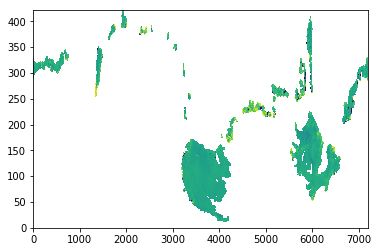

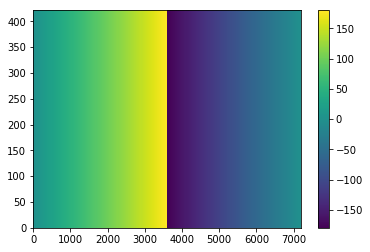

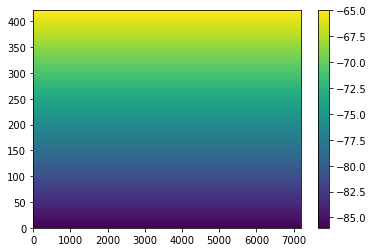

In [109]:
plt.close()
plt.pcolormesh(wb.w_b)
plt.show()
plt.pcolormesh(lon_s)
plt.colorbar()
plt.show()
plt.pcolormesh(lat_s)
plt.colorbar()
plt.show()

In [111]:
w_b_resampled = resample(lon_s,lat_s,grid.lon_rho.values,grid.lat_rho.values,wb.w_b.values)

In [113]:
wb_res = w_b_resampled.data
wb_res[w_b_resampled.mask] = np.nan

In [114]:
wb_res = NDinterp(wb_res)

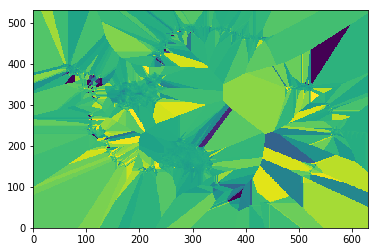

In [115]:
plt.close()
plt.pcolormesh(wb_res)
plt.show()

In [116]:
wb_res *= 917/1025
wb_res *= 1/(365*24*3600)

In [158]:
file_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_v2.0_frc','waom10_small_nudge.nc')
nudge = xr.open_dataset(file_path)

In [159]:
nudge.sst_time

<xarray.DataArray 'sst_time' (sst_time: 12)>
array([ 1313999971200000,  3942000000000000,  6570000028800000,
        9197999971200000, 11826000000000000, 14454000028800000,
       17081999971200000, 19710000000000000, 22338000028800000,
       24965999971200000, 27594000000000000, 30222000028800000], dtype='timedelta64[ns]')
Coordinates:
  * sst_time  (sst_time) timedelta64[ns] 15 days 04:59:59.971200 ...
Attributes:
    long_name:     time since initialization
    cycle_length:  365.0

In [160]:
nudge['wb'] = xr.DataArray(np.tile(wb_res,(12,1,1)),dims=['sst_time','eta_rho','xi_rho'],attrs=wb.attrs,coords={'sst_time':nudge.sst_time})

In [162]:
nudge.wb.attrs['units']='m. of ice per year (ice density 917 kg m^-3)'
nudge.wb.attrs['sign']='+ = melting; - = freezing'

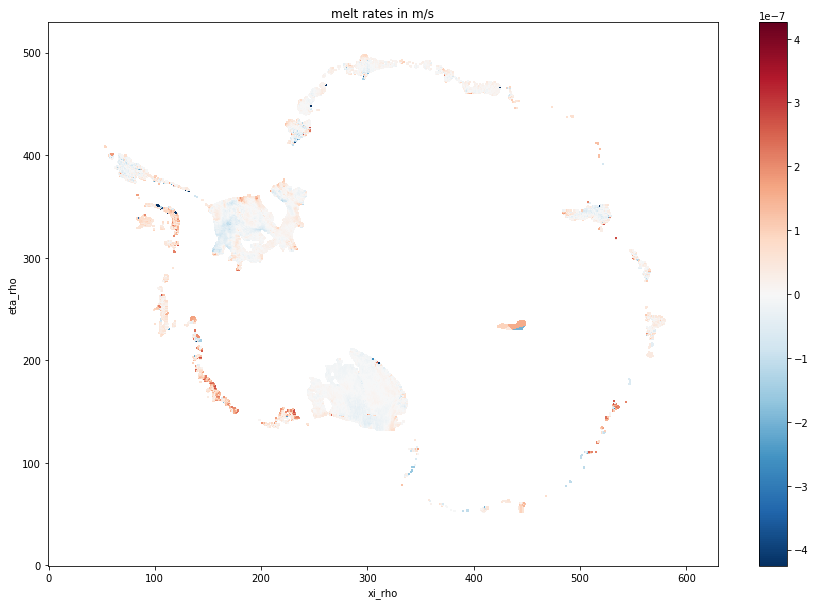

In [163]:
plt.close()
nudge.wb[-1].where(((grid.mask_rho==1)&(grid.zice<0))).plot(size=10)
plt.title('melt rates in m/s')
plt.show()

In [164]:
out_path = os.path.join(file_path,os.pardir,'waom10_small_nudge_wb.nc')
nudge.to_netcdf(out_path)

# compare resulting melt

In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [13]:
frc_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_v2.0_frc','waom10_small_nudge_wb.nc')
frc = xr.open_dataset(frc_path)
avg_path = os.path.join(os.environ.get('rawdir'),'waom10_wb','ocean_avg_001?.nc')
avg = xr.open_mfdataset(avg_path)

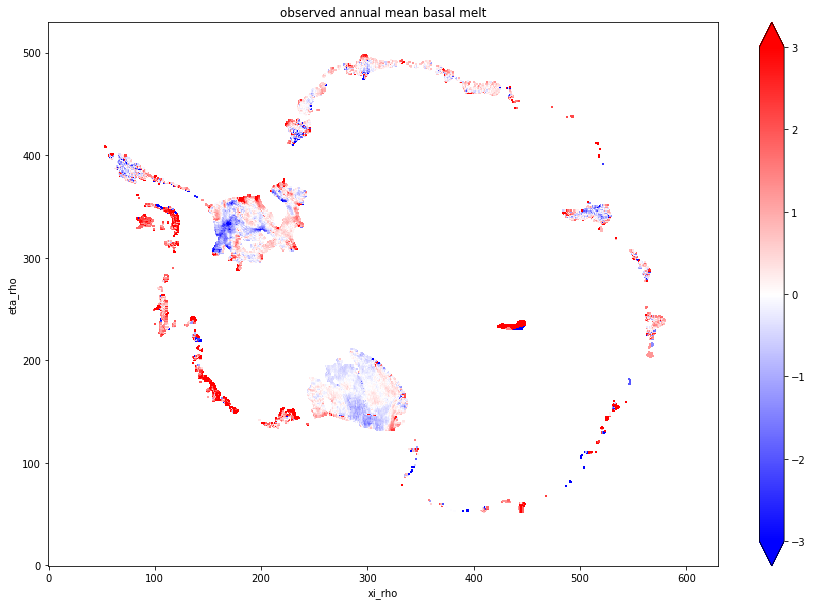

In [25]:
plt.close()
(frc.wb[0]*(365*24*3600)).where(((grid.mask_rho==1)&(grid.zice<0))).plot(vmin=-3,vmax=3,cmap=plt.cm.bwr,size=10)
plt.title("observed annual mean basal melt")
plt.show()

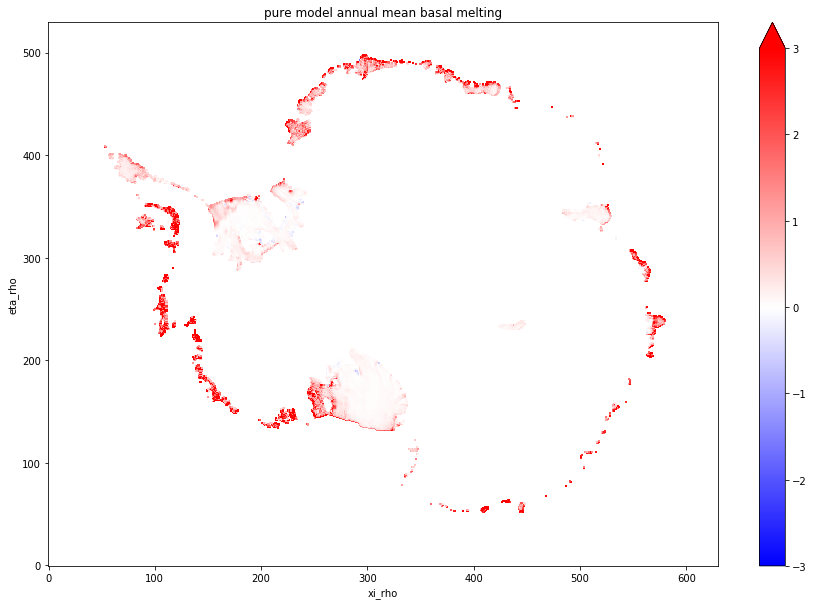

In [27]:
file_path = os.path.join(os.environ.get('rawdir'),'waom10_v2.0_small','ocean_avg_spinUp_0009.nc')
avg_no_frc = xr.open_dataset(file_path)
(avg_no_frc.m*(365*24*3600)).mean('ocean_time').where(((grid.mask_rho==1)&(grid.zice<0))).plot(vmin=-3,vmax=3,cmap=plt.cm.bwr,size=10)
plt.title("pure model annual mean basal melting")
plt.show()

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


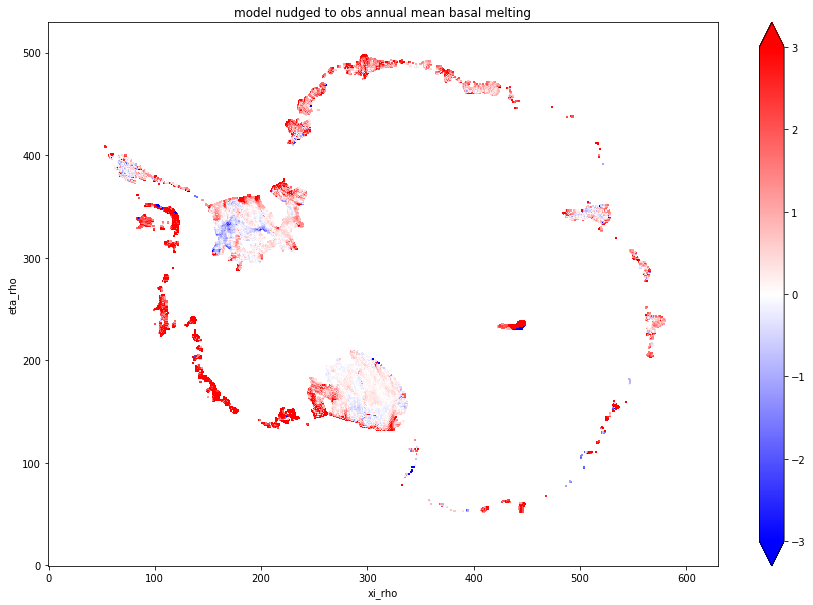

In [28]:
plt.close()
(avg.m[12:24]*(365*24*3600)).mean('ocean_time').where(((grid.mask_rho==1)&(grid.zice<0))).plot(vmin=-3,vmax=3,cmap=plt.cm.bwr,size=10)
plt.title("model nudged to obs annual mean basal melting")
plt.show()